# PINN: Harmonic oscillator

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu
from scipy.integrate import solve_ivp

## neural net

In [24]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(1, 20) # layers of neural net
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 1)
        
    def forward(self, x):
        out=torch.tanh(self.l1(x)) # does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        out=torch.tanh(self.l4(out))
        out=self.l5(out)
        return out
    

k=1
eps=0.33
def f(net,t): #differential equation loss
    u=net(t)
    v = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    a = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    mse1=nn.MSELoss()
    pt02 = Variable(torch.zeros((1000,1)).float(), requires_grad=False).to(device)
    return mse1(k*u+a-eps*k*(1-u*u)*v,pt02)

def u_err(net,t0,u0): # initial condition loss (position u0 at time t0)
    u=net(t0)
    mse1=nn.MSELoss()
    return mse1(u,u0)

def u_err_v(net,t0,v0): # initial condition loss (velocity v0 at time t0)
    u=net(t0)
    v0net=torch.autograd.grad(u.sum(), t0, create_graph=True)[0]
    mse1=nn.MSELoss()
    return mse1(v0net,v0)


Using cpu device


## train model

In [25]:

model = NeuralNetwork().to(device)
optimizer=torch.optim.Adam(model.parameters())
for i in range(20000):
    optimizer.zero_grad()
    pt_t_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=True).to(device) # t boundary condition
    pt_u_bc = Variable(torch.tensor([[1.0]]).float(), requires_grad=False).to(device) # position at t_bc
    pt_v_bc = Variable(torch.tensor([[0.0]]).float(), requires_grad=False).to(device) # velocity at t_bc
    
    loss1=u_err(model,pt_t_bc,pt_u_bc)+u_err_v(model,pt_t_bc,pt_v_bc) #initial condition loss

    t=np.random.rand(1000,1)*10.0#*min((3+7.0/10000.0*i),10.0) #collocation points
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    loss2=f(model,pt_t) #physics loss
    
    loss = loss1+loss2

    # Backpropagation
    loss.backward()
    optimizer.step()

print(f'loss={loss}')

loss=7.351623935392126e-05


## plot results

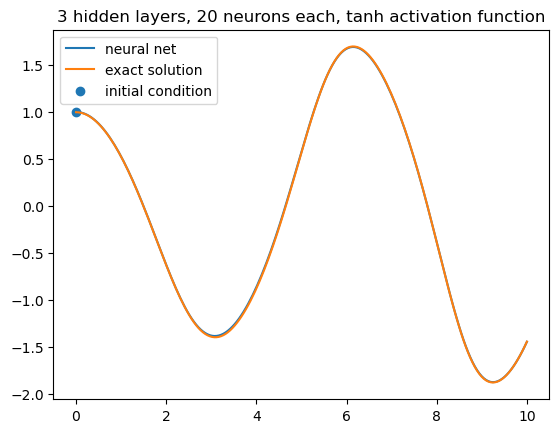

In [29]:
pt_t_test = torch.linspace(0,10,200).reshape(200,1)  #time interval for test
u_test=model(pt_t_test) #solve DGL with PINN
plt.plot(t_test,u_test.detach().numpy()) #plot PINN output


#solve with normal DGL solver
def vdp(t, z):
    x, y = z
    return [y, eps*(1 - x**2)*y - x]
sol = solve_ivp(vdp, [0, 10], [1, 0], t_eval=t_test[:,0])
plt.plot(t_test, sol.y[0])

plt.scatter(0,1)

#legend
plt.title('3 hidden layers, 20 neurons each, tanh activation function')
plt.legend(['neural net','exact solution','initial condition'])